In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, log_loss
from sklearn import neighbors
from sklearn.dummy import DummyClassifier

from mlxtend.evaluate import paired_ttest_5x2cv

# Data set

In [2]:
data = pd.read_csv("iris_dataset.csv")
data.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# split data into training and test set
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]


# Exploration

## Overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sepallength  150 non-null    float64
 1   sepalwidth   150 non-null    float64
 2   petallength  150 non-null    float64
 3   petalwidth   150 non-null    float64
 4   class        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
data.isnull().sum()

sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
class          0
dtype: int64

In [6]:
data.groupby("class").count()

,sepallength,sepalwidth,petallength,petalwidth
class,,,,
Iris-setosa,50,50,50,50
Iris-versicolor,50,50,50,50
Iris-virginica,50,50,50,50


In [7]:
data.describe()

,sepallength,sepalwidth,petallength,petalwidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
corr = data.corr()
corr

,sepallength,sepalwidth,petallength,petalwidth
sepallength,1.000000,-0.109369,0.871754,0.817954
sepalwidth,-0.109369,1.000000,-0.420516,-0.356544
petallength,0.871754,-0.420516,1.000000,0.962757
petalwidth,0.817954,-0.356544,0.962757,1.000000


## Plots

<AxesSubplot:xlabel='petalwidth', ylabel='Count'>

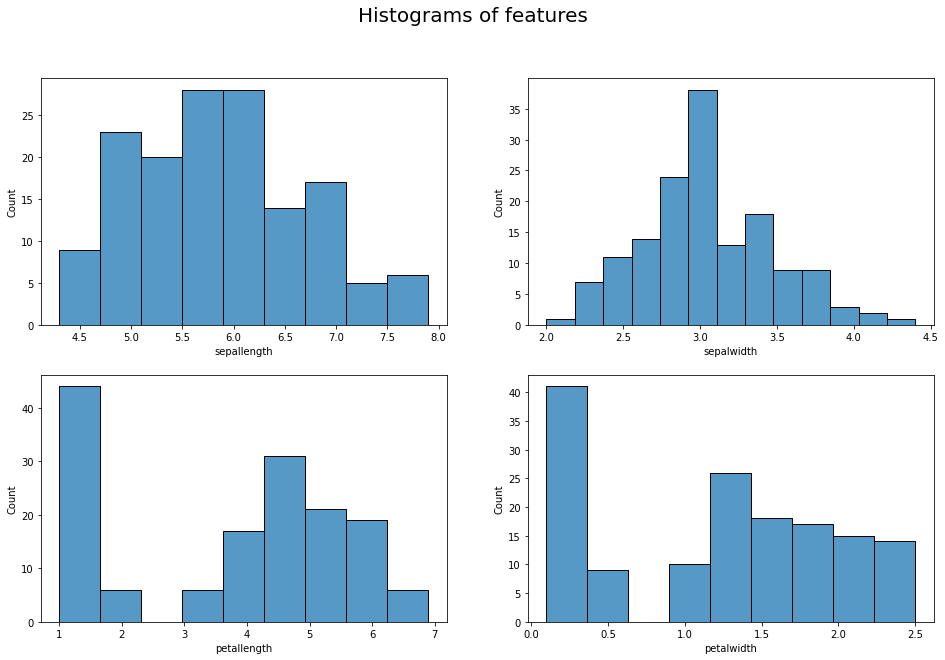

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
fig.suptitle("Histograms of features", fontsize=20)
sns.histplot(data=data["sepallength"], ax=axs[0, 0])
sns.histplot(data=data["sepalwidth"], ax=axs[0, 1])
sns.histplot(data=data["petallength"], ax=axs[1, 0])
sns.histplot(data=data["petalwidth"], ax=axs[1, 1])

<AxesSubplot:>

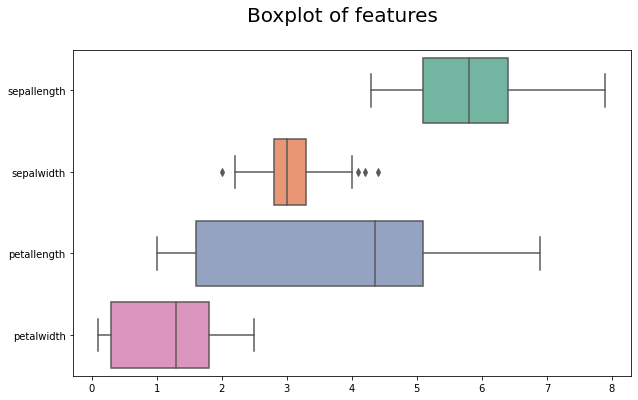

In [10]:
fig, axs = plt.subplots(figsize=(10, 6))
fig.suptitle("Boxplot of features", fontsize=20)
sns.boxplot(data=X, orient="h", palette="Set2")

<AxesSubplot:>

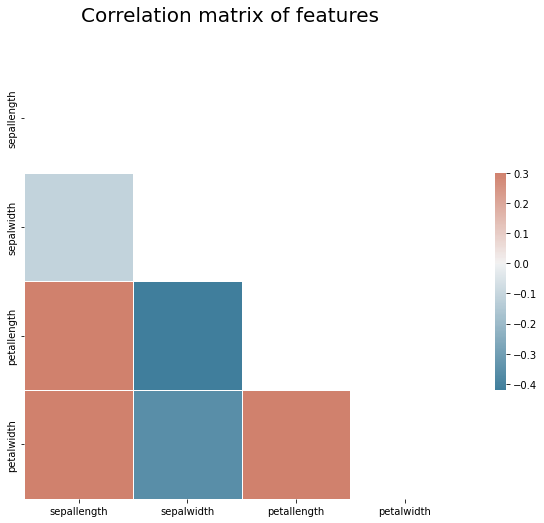

In [11]:
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, axs = plt.subplots(figsize=(13, 8))
fig.suptitle("Correlation matrix of features", fontsize=20)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:xlabel='class', ylabel='petalwidth'>

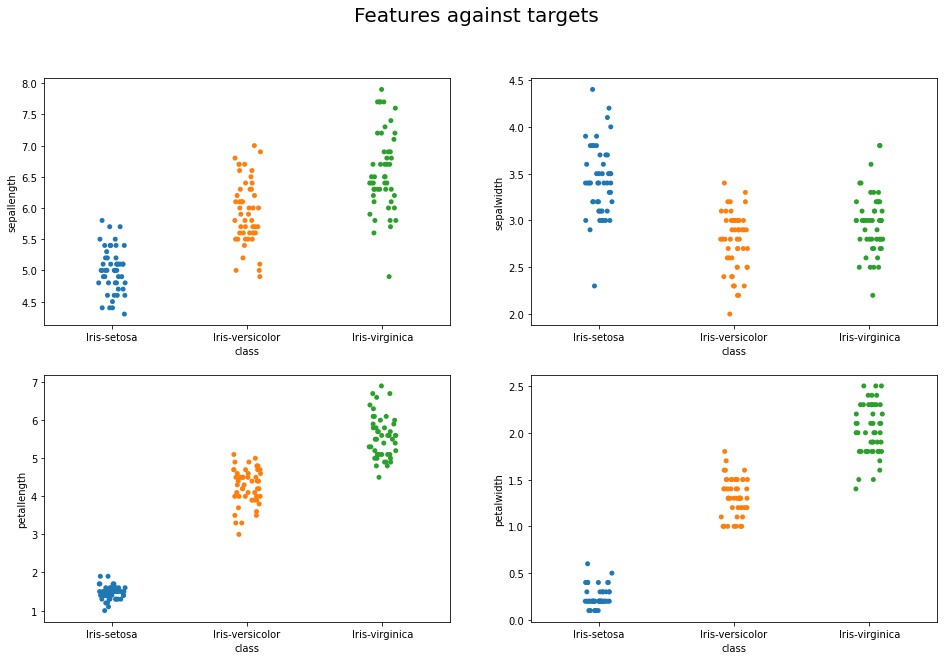

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
fig.suptitle("Features against targets", fontsize=20)
sns.stripplot(data=data, x="class", y="sepallength", ax=axs[0, 0])
sns.stripplot(data=data, x="class", y="sepalwidth", ax=axs[0, 1])
sns.stripplot(data=data, x="class", y="petallength", ax=axs[1, 0])
sns.stripplot(data=data, x="class", y="petalwidth", ax=axs[1, 1])

# Pre-processing

## Feature selection

In [ ]:
# not needed

## Feature scaling

In [13]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# [TODO] maybe normalize 

## Encoding

In [14]:
enc = LabelEncoder()
y_encoded = enc.fit_transform(y.values.ravel())

# Model selection

In [15]:
# K-NN
knn_classifiers = {
    "KNN [1, uniform]": neighbors.KNeighborsClassifier(n_neighbors=1),
    "KNN [1, distance]": neighbors.KNeighborsClassifier(n_neighbors=1, weights="distance"),
    "KNN [3, uniform]": neighbors.KNeighborsClassifier(n_neighbors=3),
    "KNN [3, distance]": neighbors.KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "KNN [5, uniform]": neighbors.KNeighborsClassifier(n_neighbors=5),
    "KNN [5, distance]": neighbors.KNeighborsClassifier(n_neighbors=5, weights="distance"),
    "KNN [10, uniform]": neighbors.KNeighborsClassifier(n_neighbors=10),
    "KNN [10, distance]": neighbors.KNeighborsClassifier(n_neighbors=10, weights="distance"),
    "KNN [15, uniform]": neighbors.KNeighborsClassifier(n_neighbors=15),
    "KNN [15, distance]": neighbors.KNeighborsClassifier(n_neighbors=15, weights="distance"),
    "KNN [20, uniform]": neighbors.KNeighborsClassifier(n_neighbors=20),
    "KNN [20, distance]": neighbors.KNeighborsClassifier(n_neighbors=20, weights="distance")
}


In [16]:
# Decision Tree
# [TODO] dictonary with different hyperparameters
# either Decision tree or Random Forest -> both tree search algorithms

In [17]:
# Random Forest
# [TODO] dictonary with different hyperparameters
# either Decision tree or Random Forest -> both tree search algorithms

In [18]:
# Support Vector Machines
# [TODO] dictonary with different hyperparameters

# Training and validation

In [19]:
# [TODO] plot confusion matrix:
# plt.figure(figsize = (10,7))
# sns.heatmap(conf_matrix, annot=True)

In [ ]:
# [TODO] compare runtime of hold-out and cross validation

## Hold-out

In [95]:
def holdout(clf, X_train, y_train):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=30)
    
    model = clf.fit(X_train, y_train)

    accuracy = accuracy_score(y_val, model.predict(X_val))
    recall = recall_score(y_val, model.predict(X_val), average="macro")
    f1 = f1_score(y_val, model.predict(X_val), average="macro")    

    return([accuracy, recall, f1, model])

## Cross-validation

In [79]:
def cross_validation(clf, X_train, y_train):
    model = clf.fit(X_train, y_train)

    accuracy = cross_val_score(model, X=X_train, y=y_train, scoring="accuracy")
    recall = cross_val_score(model, X=X_train, y=y_train, scoring="recall_macro")
    f1 = cross_val_score(model, X=X_train, y=y_train, scoring="f1_macro")    

    return([np.mean(accuracy), np.mean(recall), np.mean(f1), model])


## Evaluate classifiers

In [93]:
def evaluate_classifiers(clf_dict, X_train, y_train):
    results = list()
    for i, (key, clf) in enumerate(clf_dict.items()):
        accuracy, recall, f1, model = holdout(clf, X_train, y_train)
        results.append([key, "hold-out", accuracy, recall, f1, model])
        accuracy, recall, f1, model = cross_validation(clf, X_train, y_train)
        results.append([key, "cross", accuracy, recall, f1, model])

    return(results)

results = evaluate_classifiers(knn_classifiers, X_scaled, y_encoded)
results_df = pd.DataFrame(results, columns =['Classifier', 'Validation', "Accuracy", "Recall (macro)", "F1 (macro)", "Model"])
results_df.drop("Model", axis=1, inplace=True)
results_df

,Classifier,Validation,Accuracy,Recall (macro),F1 (macro)
0,"KNN [1, uniform]",hold-out,0.964286,0.958333,0.963285
1,"KNN [1, uniform]",cross,0.928854,0.927381,0.927834
2,"KNN [1, distance]",hold-out,0.964286,0.958333,0.963285
3,"KNN [1, distance]",cross,0.928854,0.927381,0.927834
4,"KNN [3, uniform]",hold-out,0.964286,0.958333,0.963285
5,"KNN [3, uniform]",cross,0.964822,0.964286,0.964204
6,"KNN [3, distance]",hold-out,0.964286,0.958333,0.963285
7,"KNN [3, distance]",cross,0.955731,0.954762,0.954632
8,"KNN [5, uniform]",hold-out,0.892857,0.886364,0.889855
9,"KNN [5, uniform]",cross,0.956126,0.954762,0.955236


# Results

## Significance tests

In [94]:
baseline = DummyClassifier(strategy="uniform", random_state=30)
baseline.fit(X_scaled, y_encoded)

#results = paired_ttest_5x2cv(estimator1=baseline, estimator2=model, X=X_test, y=y_test.values.ravel(), scoring='accuracy', random_seed=30)

DummyClassifier(random_state=30, strategy='uniform')